In [1]:
from risk_experiment.utils import Subject, get_all_subjects, get_all_behavior
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pingouin

from tqdm.contrib.itertools import product
import pandas as pd

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
r = []
decoded_stimuli = []
keys = []

for sub, session, mask, n_voxels in product(get_all_subjects('/data/ds-risk'), ['3t2', '7t2'], ['npcl', 'npcr'], [0, 100, 250]):
    pred = sub.get_decoding_info(session, n_voxels=n_voxels, mask=mask)
    behavior = sub.get_behavior(sessions=session)

    tmp = pred.join(behavior[['n1']])

    r.append({'subject':sub.subject, 'session':session, 'r':pingouin.corr(tmp['n1'], tmp['E'])['r'].iloc[0],
    'mask':mask, 'n_voxels':n_voxels})

    decoded_stimuli.append(pred)
    keys.append((sub.subject, session, mask, n_voxels))

r = pd.DataFrame(r).set_index(['subject', 'session', 'mask', 'n_voxels'])

decoded_stimuli = pd.concat(decoded_stimuli)


  0%|          | 0/360 [00:00<?, ?it/s]

/Users/gdehol/mambaforge/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
behavior = get_all_behavior(bids_folder='/data/ds-risk')

100%|██████████| 30/30 [00:01<00:00, 17.29it/s]


In [4]:
import arviz as az
import os.path as op

session = '3t2'

bids_folder = '/data/ds-risk'
model_label = '1'

sessions = ['3t2', '7t2']

n1_evidence_sd = []
n2_evidence_sd = []

for session in sessions:
    idata = az.from_netcdf(op.join(bids_folder, f'derivatives/cogmodels/ses-{session}_model-{model_label}_trace.netcdf'))
    n1_evidence_sd.append(idata.posterior['n1_evidence_sd'].to_dataframe().groupby('subject').mean())
    n2_evidence_sd.append(idata.posterior['n2_evidence_sd'].to_dataframe().groupby('subject').mean())

n1_evidence_sd = pd.concat(n1_evidence_sd, keys=sessions, names=['session'])
n2_evidence_sd = pd.concat(n2_evidence_sd, keys=sessions, names=['session'])

n1_evidence_sd = n1_evidence_sd.reset_index('subject')
n1_evidence_sd['subject'] = n1_evidence_sd['subject'].apply(lambda d: f'{d:02d}')
n1_evidence_sd = n1_evidence_sd.set_index('subject', append=True).swaplevel().sort_index()

n2_evidence_sd = n2_evidence_sd.reset_index('subject')
n2_evidence_sd['subject'] = n2_evidence_sd['subject'].apply(lambda d: f'{d:02d}')
n2_evidence_sd = n2_evidence_sd.set_index('subject', append=True).swaplevel().sort_index()

n         r           CI95%     p-val  \
session mask n_voxels                                                   
3t2     npcl 0        pearson  30 -0.596348   [-0.79, -0.3]  0.000505   
             100      pearson  30 -0.512680  [-0.74, -0.19]  0.003770   
             250      pearson  30 -0.399743  [-0.66, -0.05]  0.028625   
        npcr 0        pearson  30 -0.479809  [-0.72, -0.14]  0.007293   
             100      pearson  30 -0.489226  [-0.72, -0.16]  0.006076   
             250      pearson  30 -0.509718  [-0.74, -0.18]  0.004012   
7t2     npcl 0        pearson  30 -0.532013  [-0.75, -0.21]  0.002479   
             100      pearson  30 -0.460194   [-0.7, -0.12]  0.010502   
             250      pearson  30 -0.504071  [-0.73, -0.18]  0.004509   
        npcr 0        pearson  30 -0.416748  [-0.68, -0.07]  0.021965   
             100      pearson  30 -0.657290  [-0.82, -0.39]  0.000079   
             250      pearson  30 -0.504699  [-0.73, -0.18]  0.004451   

                                  BF10     power  
session mask n_voxels                             
3t2     npcl 0        pearson    72.41  0.951664  
             100      pearson    12.42  0.847187  
             250      pearson    2.233  0.606892  
        npcr 0        pearson    7.039  0.786646  
             100      pearson    8.231  0.805002  
             250      pearson   11.771  0.842153  
7t2     npcl 0        pearson   17.878  0.877858  
             100      pearson    5.161  0.746093  
             250      pearson    10.64  0.832315  
        npcr 0        pearson    2.778  0.647574  
             100      pearson  377.971  0.985710  
             250      pearson   10.759  0.833424

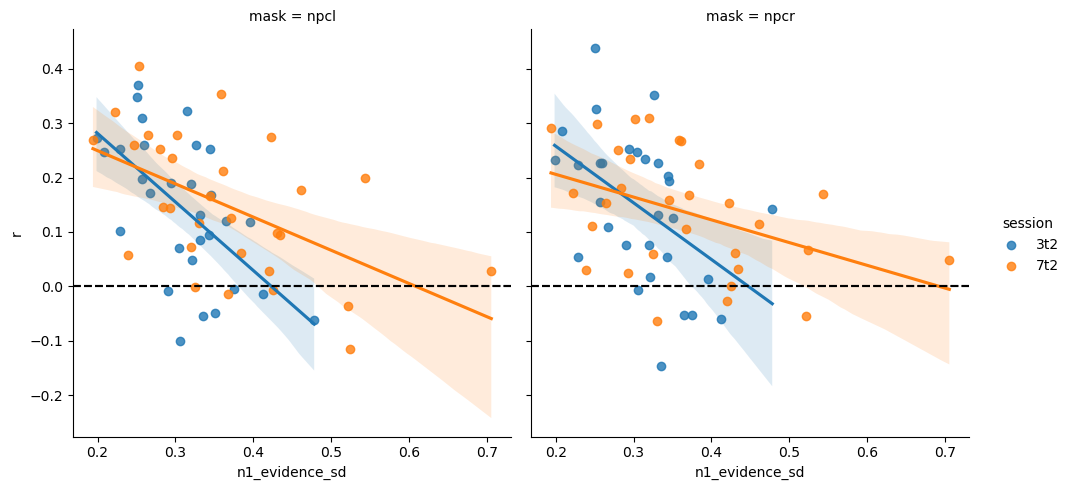

In [5]:
tmp = r.join(n1_evidence_sd)


g = sns.lmplot(tmp.xs(0, 0, 'n_voxels').reset_index(), x='n1_evidence_sd', y='r', col='mask', hue='session')

g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))
tmp.groupby(['session', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n1_evidence_sd']))

n         r          CI95%     p-val   BF10  \
session mask n_voxels                                                         
3t2     npcl 0        pearson  30 -0.152866  [-0.49, 0.22]  0.419977   0.31   
             100      pearson  30 -0.165628   [-0.5, 0.21]  0.381738  0.327   
             250      pearson  30 -0.061774  [-0.41, 0.31]  0.745723  0.239   
        npcr 0        pearson  30 -0.163634  [-0.49, 0.21]  0.387575  0.324   
             100      pearson  30 -0.069612   [-0.42, 0.3]  0.714722  0.242   
             250      pearson  30  0.011918  [-0.35, 0.37]  0.950160  0.227   
7t2     npcl 0        pearson  30 -0.272188   [-0.58, 0.1]  0.145635  0.624   
             100      pearson  30 -0.152970  [-0.49, 0.22]  0.419657   0.31   
             250      pearson  30 -0.101805  [-0.45, 0.27]  0.592435   0.26   
        npcr 0        pearson  30 -0.272667   [-0.58, 0.1]  0.144899  0.626   
             100      pearson  30 -0.278287  [-0.58, 0.09]  0.136469  0.654   
             250      pearson  30 -0.188590  [-0.51, 0.18]  0.318255  0.365   

                                  power  
session mask n_voxels                    
3t2     npcl 0        pearson  0.127784  
             100      pearson  0.142071  
             250      pearson  0.061742  
        npcr 0        pearson  0.139753  
             100      pearson  0.065089  
             250      pearson  0.049939  
7t2     npcl 0        pearson  0.312681  
             100      pearson  0.127895  
             250      pearson  0.083298  
        npcr 0        pearson  0.313646  
             100      pearson  0.325080  
             250      pearson  0.171096

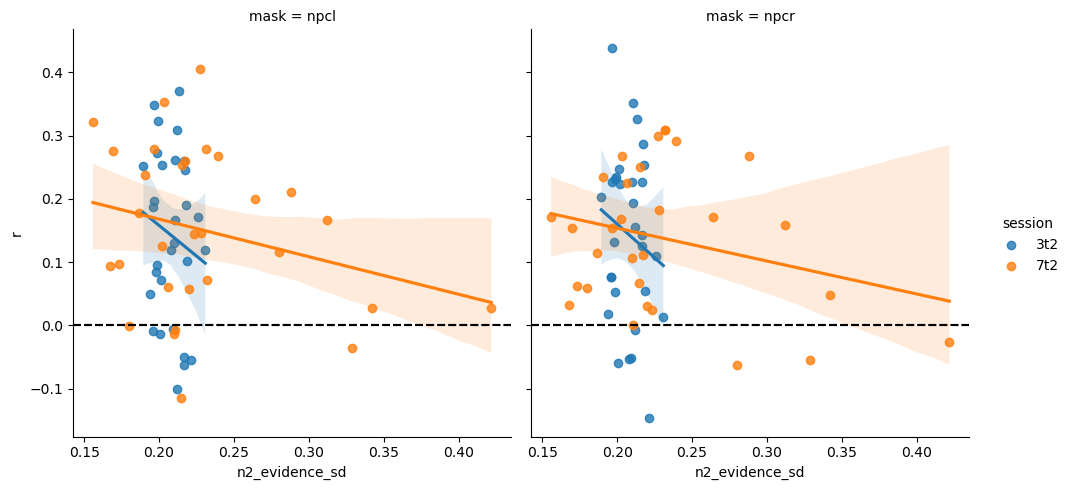

In [6]:
tmp = r.join(n2_evidence_sd)


g = sns.lmplot(tmp.xs(0, 0, 'n_voxels').reset_index(), x='n2_evidence_sd', y='r', col='mask', hue='session')

g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))
tmp.groupby(['session', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n2_evidence_sd']))

n         r          CI95%     p-val   BF10  \
session mask n_voxels                                                         
3t2     npcl 0        pearson  30  0.378285   [0.02, 0.65]  0.039282  1.725   
             100      pearson  30 -0.023729  [-0.38, 0.34]  0.900950  0.229   
             250      pearson  30 -0.109976  [-0.45, 0.26]  0.562907  0.266   
        npcr 0        pearson  30  0.444151    [0.1, 0.69]  0.013940  4.063   
             100      pearson  30 -0.041535   [-0.4, 0.32]  0.827488  0.232   
             250      pearson  30 -0.114100  [-0.46, 0.26]  0.548266   0.27   
7t2     npcl 0        pearson  30  0.441391    [0.1, 0.69]  0.014617  3.904   
             100      pearson  30 -0.000603  [-0.36, 0.36]  0.997477  0.227   
             250      pearson  30 -0.178053  [-0.51, 0.19]  0.346527  0.347   
        npcr 0        pearson  30  0.379662   [0.02, 0.65]  0.038514  1.752   
             100      pearson  30  0.118589  [-0.25, 0.46]  0.532530  0.273   
             250      pearson  30 -0.100492  [-0.44, 0.27]  0.597241  0.259   

                                  power  
session mask n_voxels                    
3t2     npcl 0        pearson  0.554859  
             100      pearson  0.051280  
             250      pearson  0.089096  
        npcr 0        pearson  0.710903  
             100      pearson  0.054998  
             250      pearson  0.092209  
7t2     npcl 0        pearson  0.704689  
             100      pearson  0.049488  
             250      pearson  0.157243  
        npcr 0        pearson  0.558206  
             100      pearson  0.095741  
             250      pearson  0.082411

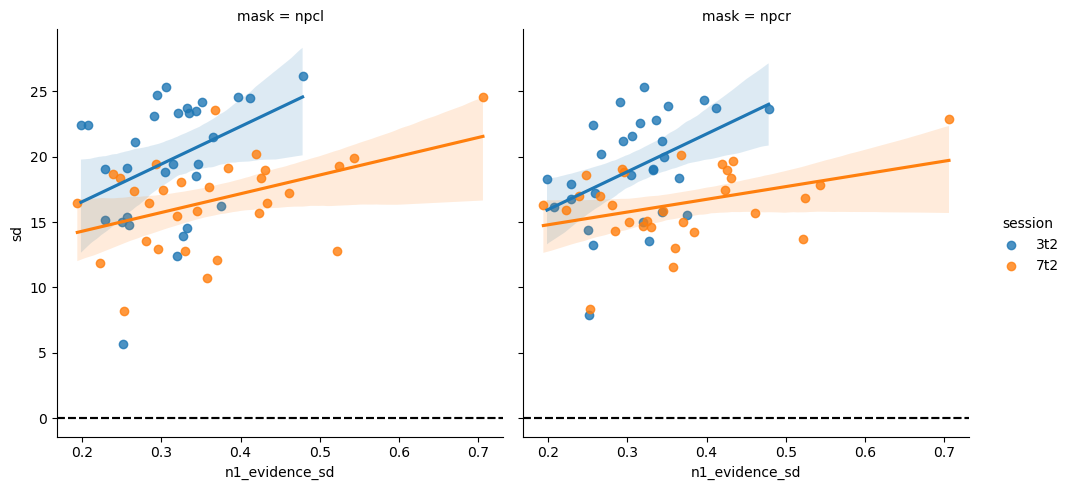

In [7]:
tmp = decoded_stimuli.groupby(['subject', 'session', 'mask', 'n_voxels']).mean().join(n1_evidence_sd)

g = sns.lmplot(tmp.xs(0, 0, 'n_voxels').reset_index(), x='n1_evidence_sd', y='sd', col='mask', hue='session')

g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))
tmp.groupby(['session', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['sd'], d['n1_evidence_sd']))

n         r          CI95%     p-val   BF10  \
session mask n_voxels                                                         
3t2     npcl 0        pearson  30  0.194573  [-0.18, 0.52]  0.302859  0.377   
             100      pearson  30 -0.043731   [-0.4, 0.32]  0.818516  0.233   
             250      pearson  30 -0.105001  [-0.45, 0.27]  0.580808  0.263   
        npcr 0        pearson  30  0.150305  [-0.22, 0.48]  0.427898  0.306   
             100      pearson  30 -0.000158  [-0.36, 0.36]  0.999341  0.227   
             250      pearson  30 -0.079902  [-0.43, 0.29]  0.674692  0.247   
7t2     npcl 0        pearson  30  0.234335  [-0.14, 0.55]  0.212613  0.477   
             100      pearson  30  0.209407  [-0.16, 0.53]  0.266739  0.409   
             250      pearson  30  0.062508   [-0.3, 0.41]  0.742802  0.239   
        npcr 0        pearson  30  0.093976  [-0.28, 0.44]  0.621341  0.255   
             100      pearson  30 -0.084373  [-0.43, 0.28]  0.657561  0.249   
             250      pearson  30 -0.169346    [-0.5, 0.2]  0.370989  0.333   

                                  power  
session mask n_voxels                    
3t2     npcl 0        pearson  0.179366  
             100      pearson  0.055599  
             250      pearson  0.085507  
        npcr 0        pearson  0.125074  
             100      pearson  0.049487  
             250      pearson  0.070121  
7t2     npcl 0        pearson  0.241755  
             100      pearson  0.201138  
             250      pearson  0.062038  
        npcr 0        pearson  0.078196  
             100      pearson  0.072535  
             250      pearson  0.146481

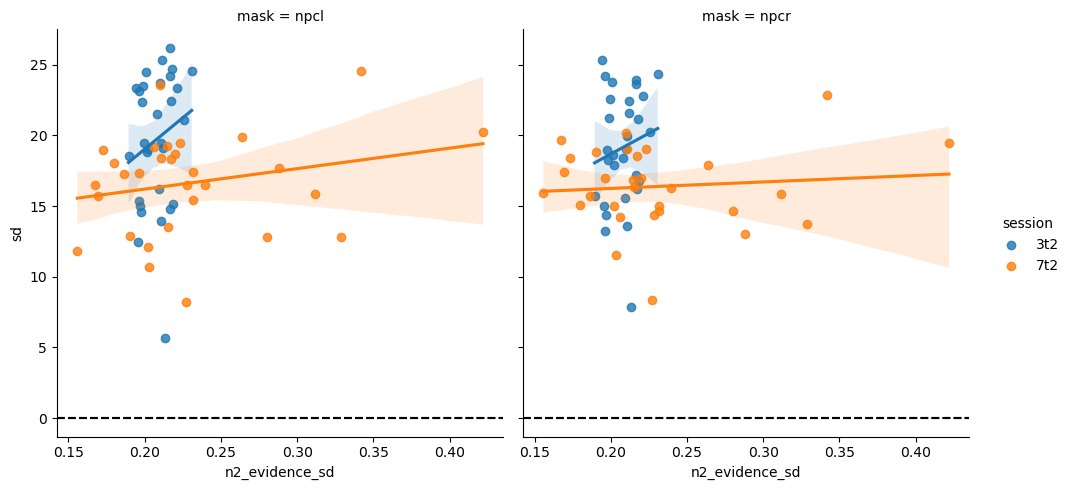

In [8]:
tmp = decoded_stimuli.groupby(['subject', 'session', 'mask', 'n_voxels']).mean().join(n2_evidence_sd)

g = sns.lmplot(tmp.xs(0, 0, 'n_voxels').reset_index(), x='n2_evidence_sd', y='sd', col='mask', hue='session')

g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))
tmp.groupby(['session', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['sd'], d['n2_evidence_sd']))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_30676/3532326951.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = tmp.groupby(['subject', 'session', 'mask', 'median_split_decoded_sd']).mean()


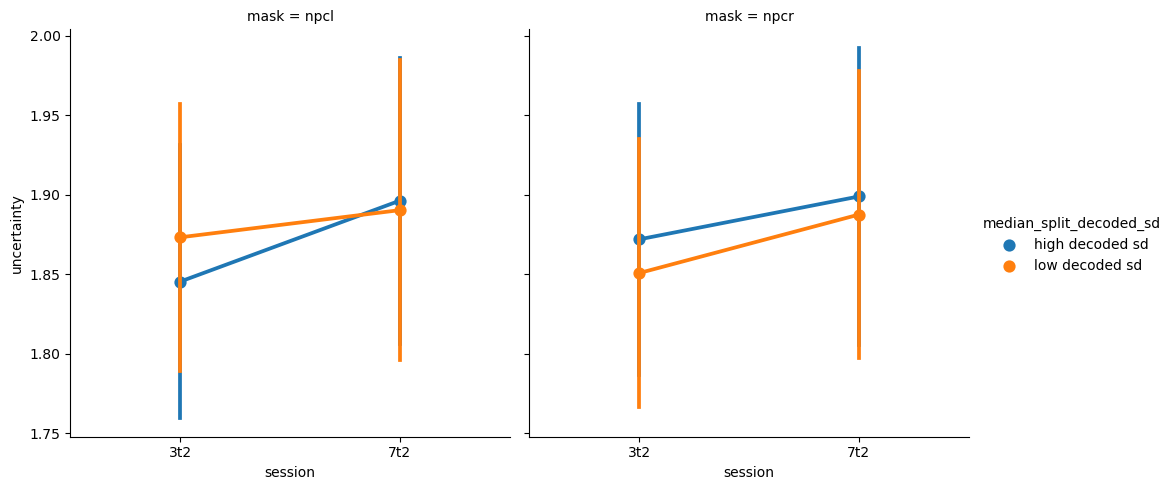

In [9]:
tmp = decoded_stimuli.xs(0, 0, 'n_voxels').join(behavior)
tmp['median_split_decoded_sd'] = tmp.groupby(['subject', 'session', 'n1', 'n2', 'risky_first'], group_keys=False).apply(lambda d: d['sd'] > d['sd'].median()).map({True:'high decoded sd', False:'low decoded sd'})
tmp = tmp.groupby(['subject', 'session', 'mask', 'median_split_decoded_sd']).mean()

sns.catplot(tmp.reset_index(), x='session', y='uncertainty', hue='median_split_decoded_sd', col='mask', kind='point', errorbar='se')

In [13]:
decoded_stimuli

E         sd
subject session mask n_voxels trial_nr                      
02      3t2     npcl 0        1          4.587391   1.631700
                              2          4.904254   2.108934
                              3         26.878214  13.410413
                              4         58.007203  13.957079
                              5         53.761389  31.886528
...                                           ...        ...
32      7t2     npcr 250      188       29.089079   7.893188
                              189       30.439491  13.893668
                              190       28.906370   9.549052
                              191       17.686063  20.070036
                              192       77.599882  28.449070

[69120 rows x 2 columns]

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_30676/3987970399.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(data=tmp.groupby(['subject', 'session', 'n_safe', 'median_split_decoded_sd', 'risky_first']).mean().reset_index(), x='n_safe', y='chose_risky',


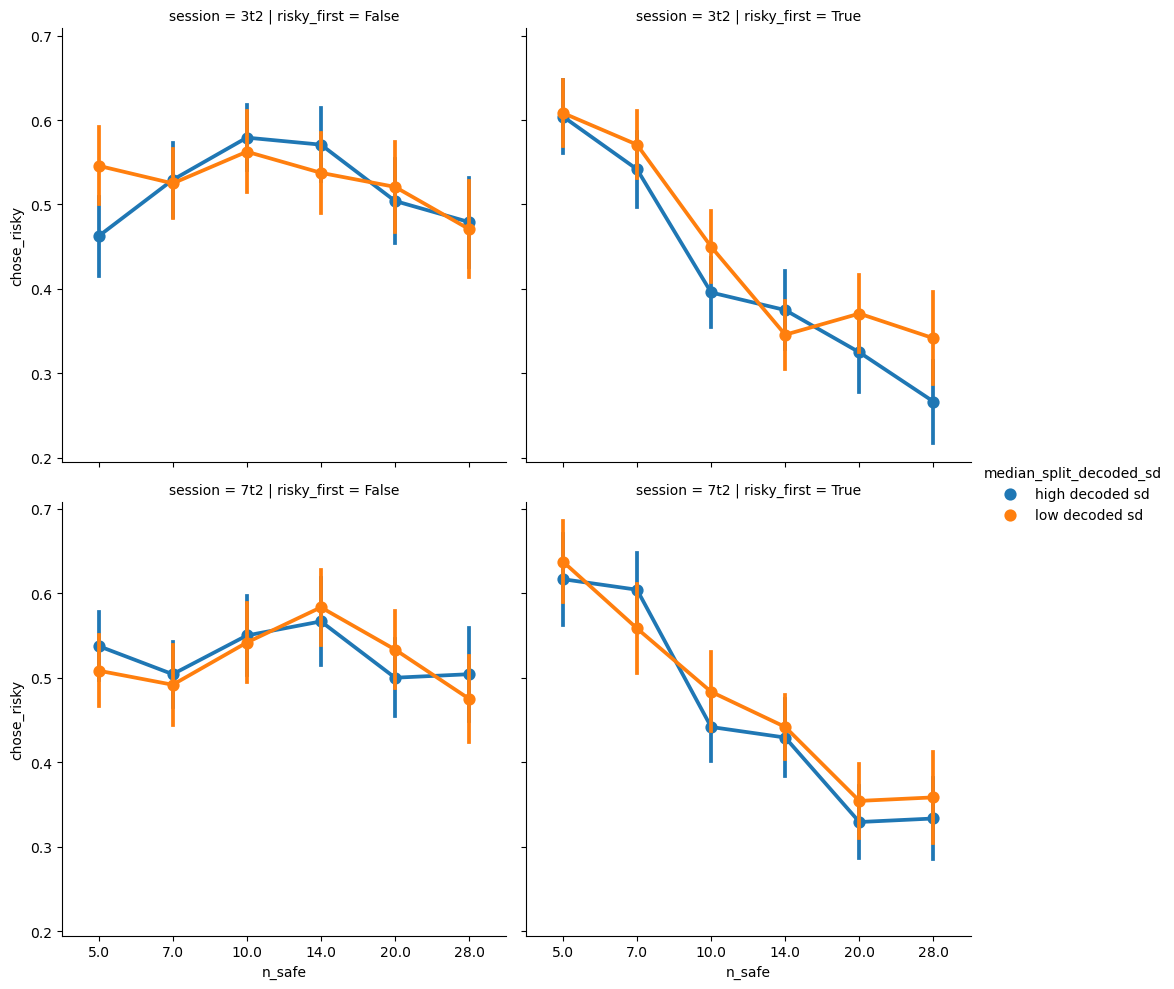

In [31]:
tmp = decoded_stimuli.xs('npcr', 0, 'mask').xs(0, 0, 'n_voxels').join(behavior)
tmp['median_split_decoded_sd'] = tmp.groupby(['subject', 'session', 'n1', 'n2', 'risky_first'], group_keys=False).apply(lambda d: d['sd'] > d['sd'].median()).map({True:'high decoded sd', False:'low decoded sd'})

sns.catplot(data=tmp.groupby(['subject', 'session', 'n_safe', 'median_split_decoded_sd', 'risky_first']).mean().reset_index(), x='n_safe', y='chose_risky',
hue='median_split_decoded_sd', kind='point', row='session',
errorbar='se',
col='risky_first')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_30676/1620312997.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(data=tmp.groupby(['subject', 'n_safe', 'median_split_decoded_sd', 'risky_first']).mean().reset_index(), x='n_safe', y='chose_risky',


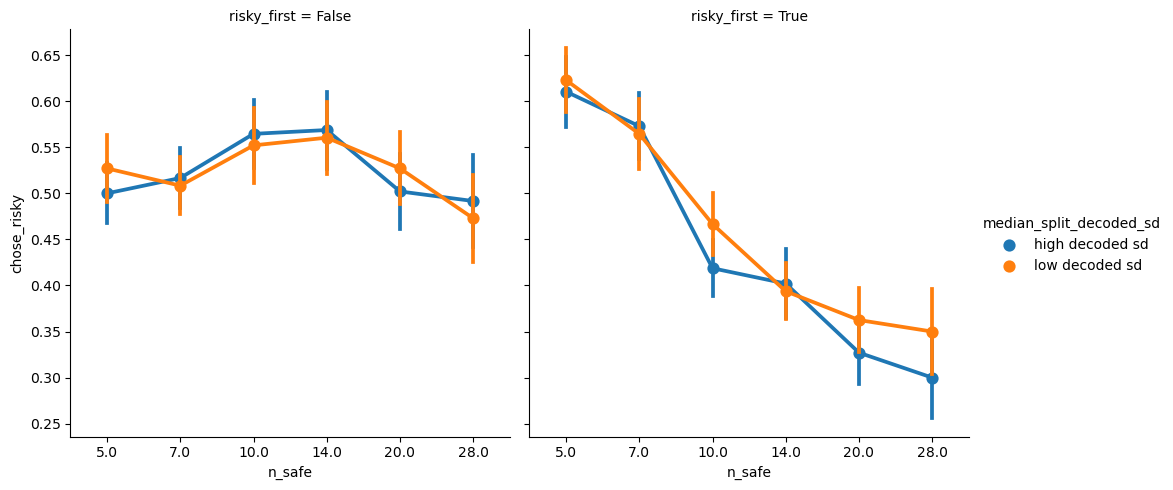

In [28]:
tmp = decoded_stimuli.xs('npcr', 0, 'mask').xs(0, 0, 'n_voxels').join(behavior)
tmp['median_split_decoded_sd'] = tmp.groupby(['subject', 'session', 'n1', 'n2', 'risky_first'], group_keys=False).apply(lambda d: d['sd'] > d['sd'].median()).map({True:'high decoded sd', False:'low decoded sd'})

sns.catplot(data=tmp.groupby(['subject', 'n_safe', 'median_split_decoded_sd', 'risky_first']).mean().reset_index(), x='n_safe', y='chose_risky',
hue='median_split_decoded_sd', kind='point',
errorbar='se',
col='risky_first')

In [18]:
import bambi

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [20]:
model = bambi.Model('chose_risky ~ median_split_decoded_sd*risky_first*n_safe + (1|subject)', data=tmp.xs('3t2', 0, 'session').reset_index())

idata = model.fit()

e = idata.posterior['median_split_decoded_sd:risky_first:n_safe'].to_dataframe()
sns.distplot(e)
(e > 0.0).mean()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, median_split_decoded_sd, risky_first, median_split_decoded_sd:risky_first, n_safe, median_split_decoded_sd:n_safe, risky_first:n_safe, median_split_decoded_sd:risky_first:n_safe, 1|subject_sigma, 1|subject_offset, chose_risky_sigma]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, median_split_decoded_sd, risky_first, median_split_decoded_sd:risky_first, n_safe, median_split_decoded_sd:n_safe, risky_first:n_safe, median_split_decoded_sd:risky_first:n_safe, 1|subject_sigma, 1|subject_offset, median_split_decoded_sd|subject_sigma, median_split_decoded_sd|subject_offset, risky_first|subject_sigma, risky_first|subject_offset, median_split_decoded_sd:risky_first|subject_sigma, median_split_decoded_sd:risky_first|subject_offset, n_safe|subject_sigma, n_safe|subject_offset, median_split_decoded_sd:n_safe|subject_sigma, median_split_decoded_sd:n_safe|subject_offset, risky_first:n_safe|subject_sigma, risky_first:n_safe|subject_offset, median_split_decoded_sd:risky_first:n_safe|subject_sigma, median_split_decoded_sd:risky_first:n_safe|subject_offset, chose_risky_sigma]
WARNING (aesara.tensor.b

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 117 seconds.
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_30676/2526681124.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(e)


median_split_decoded_sd:risky_first:n_safe    0.616
dtype: float64

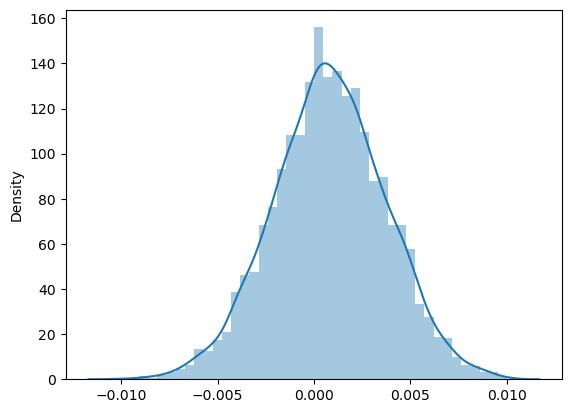

In [32]:
model = bambi.Model('chose_risky ~ median_split_decoded_sd*risky_first*n_safe + (median_split_decoded_sd*risky_first*n_safe|subject)', data=tmp.xs('7t2', 0, 'session').reset_index())

idata = model.fit()

e = idata.posterior['median_split_decoded_sd:risky_first:n_safe'].to_dataframe()
sns.distplot(e)
(e > 0.0).mean()

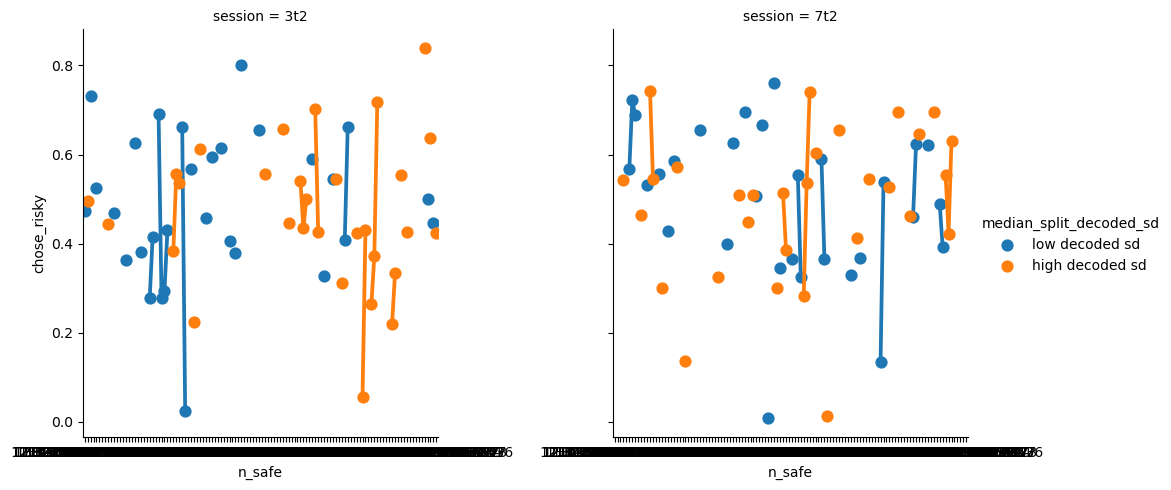

In [10]:
sns.catplot(data=tmp.xs('npcr', 0, 'mask').groupby(['subject', 'session', 'n_safe', 'median_split_decoded_sd']).mean().reset_index(), x='n_safe', y='chose_risky',
hue='median_split_decoded_sd', kind='point',
errorbar='se',
col='session')

In [19]:
tmp

E         sd        rt  \
subject session trial_nr mask run                                   
02      3t2     1        npcl 1     4.587391   1.631700  1.096017   
                         npcr 1    12.959348   8.327574  1.096017   
                2        npcl 1     4.904254   2.108934  1.324627   
                         npcr 1     7.178416   2.850978  1.324627   
                3        npcl 1    26.878214  13.410413  1.224786   
...                                      ...        ...       ...   
32      7t2     190      npcr 8    42.735755  12.117873  0.508297   
                191      npcl 8    41.343014  30.467888  0.508506   
                         npcr 8    28.431161  26.353918  0.508506   
                192      npcl 8    14.967328  11.598537  0.542275   
                         npcr 8    43.583175  16.456710  0.542275   

                                   uncertainty  z_uncertainty  \
subject session trial_nr mask run                               
02      3t2     1        npcl 1            1.0      -1.508735   
                         npcr 1            1.0      -1.508735   
                2        npcl 1            1.0      -1.508735   
                         npcr 1            1.0      -1.508735   
                3        npcl 1            3.0       0.997077   
...                                        ...            ...   
32      7t2     190      npcr 8            1.0      -0.535805   
                191      npcl 8            1.0      -0.535805   
                         npcr 8            1.0      -0.535805   
                192      npcl 8            2.0       1.856628   
                         npcr 8            2.0       1.856628   

                                  median_split_uncertainty    n1    n2  prob1  \
subject session trial_nr mask run                                               
02      3t2     1        npcl 1            low uncertainty   5.0   5.0   0.55   
                         npcr 1            low uncertainty   5.0   5.0   0.55   
                2        npcl 1            low uncertainty   7.0   7.0   0.55   
                         npcr 1            low uncertainty   7.0   7.0   0.55   
                3        npcl 1           high uncertainty  37.0  20.0   0.55   
...                                                    ...   ...   ...    ...   
32      7t2     190      npcr 8            low uncertainty  34.0  28.0   0.55   
                191      npcl 8            low uncertainty  34.0  28.0   0.55   
                         npcr 8            low uncertainty  34.0  28.0   0.55   
                192      npcl 8           high uncertainty  28.0   7.0   0.55   
                         npcr 8           high uncertainty  28.0   7.0   0.55   

                                   prob2  ...  risky_first  chose_risky  \
subject session trial_nr mask run         ...                             
02      3t2     1        npcl 1      1.0  ...         True        False   
                         npcr 1      1.0  ...         True        False   
                2        npcl 1      1.0  ...         True        False   
                         npcr 1      1.0  ...         True        False   
                3        npcl 1      1.0  ...         True        False   
...                                  ...  ...          ...          ...   
32      7t2     190      npcr 8      1.0  ...         True        False   
                191      npcl 8      1.0  ...         True        False   
                         npcr 8      1.0  ...         True        False   
                192      npcl 8      1.0  ...         True        False   
                         npcr 8      1.0  ...         True        False   

                                         Order  n_risky  n_safe      frac  \
subject session trial_nr mask run                                           
02      3t2     1        npcl 1    Risky first      5.0     5.0  1.000000   
                         npcr 1    Ris

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_48365/3277479770.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(data=tmp.xs('npcr', 0, 'mask').groupby(['subject', 'session', 'n_safe', 'median_split_decoded_sd', 'risky_first']).mean().reset_index(), x='n_safe', y='chose_risky',


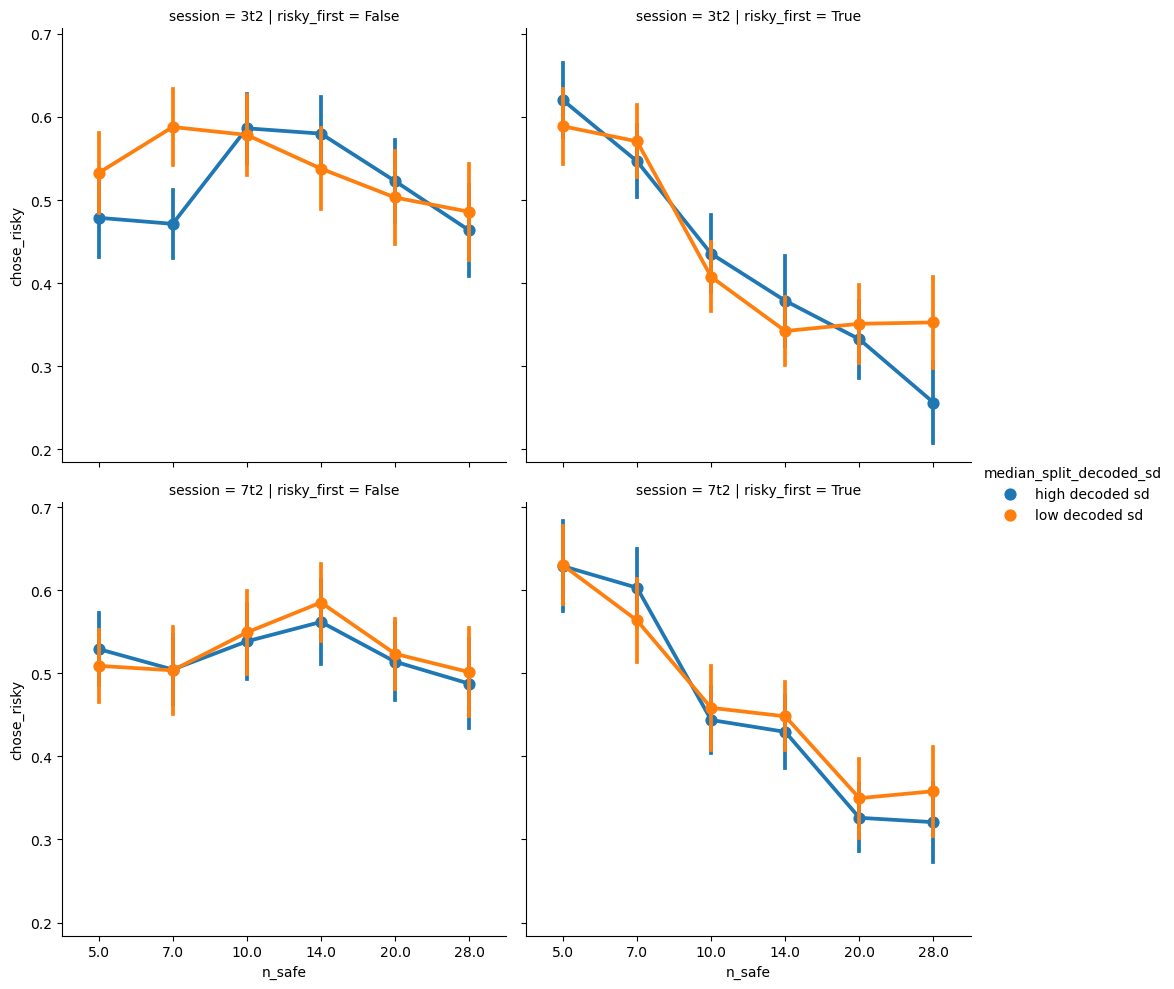

In [20]:
sns.catplot(data=tmp.xs('npcr', 0, 'mask').groupby(['subject', 'session', 'n_safe', 'median_split_decoded_sd', 'risky_first']).mean().reset_index(), x='n_safe', y='chose_risky',
hue='median_split_decoded_sd', kind='point',
errorbar='se',
col='risky_first', row='session')

In [21]:
tmp

E         sd        rt  \
subject session trial_nr mask run                                   
02      3t2     1        npcl 1     4.587391   1.631700  1.096017   
                         npcr 1    12.959348   8.327574  1.096017   
                2        npcl 1     4.904254   2.108934  1.324627   
                         npcr 1     7.178416   2.850978  1.324627   
                3        npcl 1    26.878214  13.410413  1.224786   
...                                      ...        ...       ...   
32      7t2     190      npcr 8    42.735755  12.117873  0.508297   
                191      npcl 8    41.343014  30.467888  0.508506   
                         npcr 8    28.431161  26.353918  0.508506   
                192      npcl 8    14.967328  11.598537  0.542275   
                         npcr 8    43.583175  16.456710  0.542275   

                                   uncertainty  z_uncertainty  \
subject session trial_nr mask run                               
02      3t2     1        npcl 1            1.0      -1.508735   
                         npcr 1            1.0      -1.508735   
                2        npcl 1            1.0      -1.508735   
                         npcr 1            1.0      -1.508735   
                3        npcl 1            3.0       0.997077   
...                                        ...            ...   
32      7t2     190      npcr 8            1.0      -0.535805   
                191      npcl 8            1.0      -0.535805   
                         npcr 8            1.0      -0.535805   
                192      npcl 8            2.0       1.856628   
                         npcr 8            2.0       1.856628   

                                  median_split_uncertainty    n1    n2  prob1  \
subject session trial_nr mask run                                               
02      3t2     1        npcl 1            low uncertainty   5.0   5.0   0.55   
                         npcr 1            low uncertainty   5.0   5.0   0.55   
                2        npcl 1            low uncertainty   7.0   7.0   0.55   
                         npcr 1            low uncertainty   7.0   7.0   0.55   
                3        npcl 1           high uncertainty  37.0  20.0   0.55   
...                                                    ...   ...   ...    ...   
32      7t2     190      npcr 8            low uncertainty  34.0  28.0   0.55   
                191      npcl 8            low uncertainty  34.0  28.0   0.55   
                         npcr 8            low uncertainty  34.0  28.0   0.55   
                192      npcl 8           high uncertainty  28.0   7.0   0.55   
                         npcr 8           high uncertainty  28.0   7.0   0.55   

                                   prob2  ...  risky_first  chose_risky  \
subject session trial_nr mask run         ...                             
02      3t2     1        npcl 1      1.0  ...         True        False   
                         npcr 1      1.0  ...         True        False   
                2        npcl 1      1.0  ...         True        False   
                         npcr 1      1.0  ...         True        False   
                3        npcl 1      1.0  ...         True        False   
...                                  ...  ...          ...          ...   
32      7t2     190      npcr 8      1.0  ...         True        False   
                191      npcl 8      1.0  ...         True        False   
                         npcr 8      1.0  ...         True        False   
                192      npcl 8      1.0  ...         True        False   
                         npcr 8      1.0  ...         True        False   

                                         Order  n_risky  n_safe      frac  \
subject session trial_nr mask run                                           
02      3t2     1        npcl 1    Risky first      5.0     5.0  1.000000   
                         npcr 1    Ris

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_48365/4281877646.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(data=tmp.xs('npcr', 0, 'mask').groupby(['subject', 'session', 'bin(risky/safe)', 'median_split_decoded_sd']).mean().reset_index(), x='bin(risky/safe)', y='chose_risky',


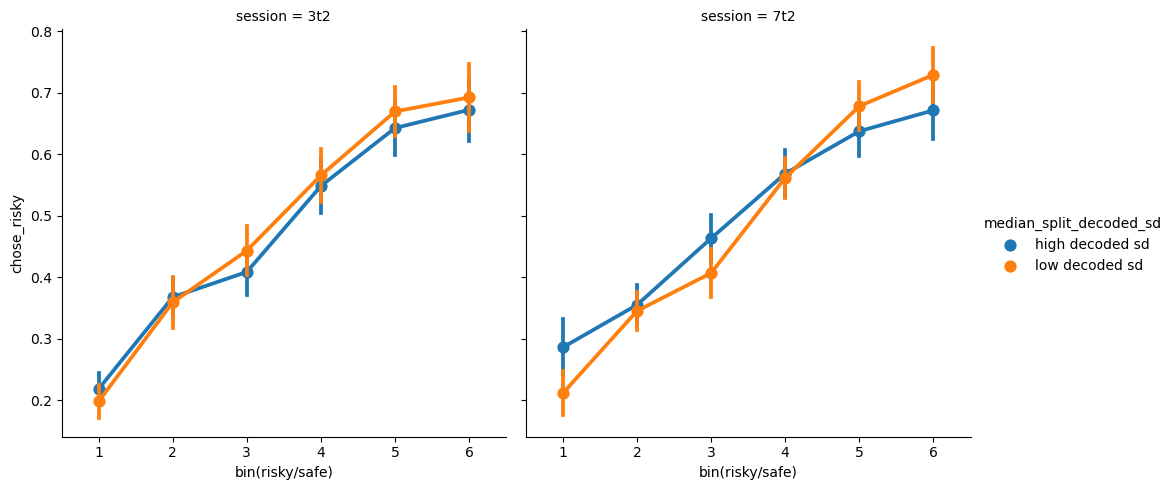

In [22]:
sns.catplot(data=tmp.xs('npcr', 0, 'mask').groupby(['subject', 'session', 'bin(risky/safe)', 'median_split_decoded_sd']).mean().reset_index(), x='bin(risky/safe)', y='chose_risky',
hue='median_split_decoded_sd', kind='point', errorbar='se', col='session')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_48365/1186706204.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(data=tmp.xs('npcr', 0, 'mask').drop(['03', '32'], level='subject').groupby(['subject', 'session', 'bin(risky/safe)', 'median_split_decoded_sd']).mean().reset_index(), x='bin(risky/safe)', y='chose_risky',


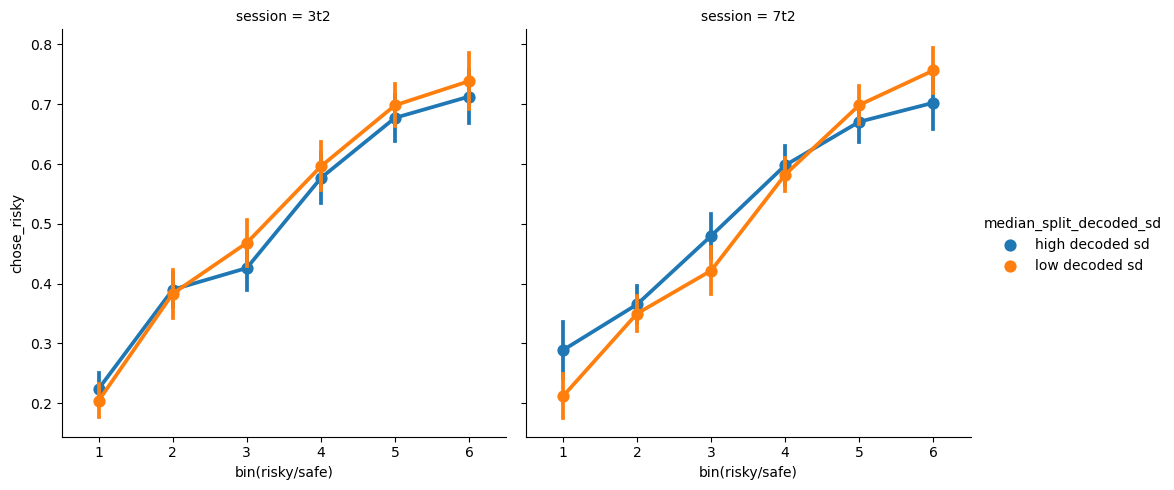

In [23]:
sns.catplot(data=tmp.xs('npcr', 0, 'mask').drop(['03', '32'], level='subject').groupby(['subject', 'session', 'bin(risky/safe)', 'median_split_decoded_sd']).mean().reset_index(), x='bin(risky/safe)', y='chose_risky',
hue='median_split_decoded_sd', kind='point', errorbar='se', col='session')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_48365/2498105782.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(data=tmp.xs('npcr', 0, 'mask').drop(['03', '32'], level='subject').groupby(['subject', 'session', 'bin(risky/safe)', 'median_split_decoded_sd']).mean().reset_index(), x='bin(risky/safe)', y='chose_risky',


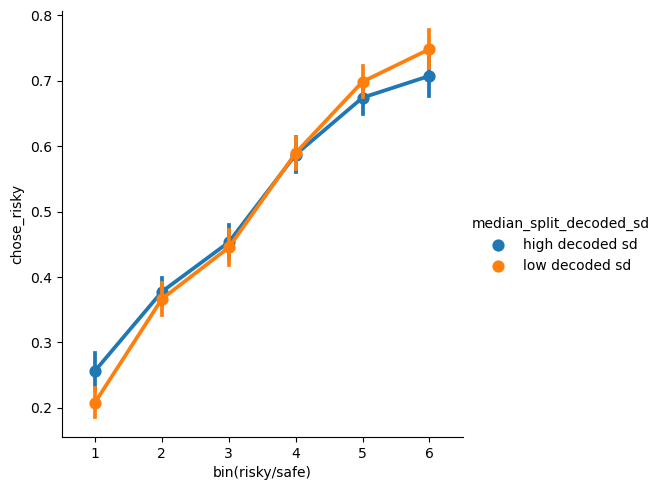

In [24]:
sns.catplot(data=tmp.xs('npcr', 0, 'mask').drop(['03', '32'], level='subject').groupby(['subject', 'session', 'bin(risky/safe)', 'median_split_decoded_sd']).mean().reset_index(), x='bin(risky/safe)', y='chose_risky',
hue='median_split_decoded_sd', kind='point', errorbar='se')

In [25]:
import arviz as az
import os.path as op
import numpy as np
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import extract_intercept_gamma
import pandas as pd
import matplotlib.pyplot as plt

bids_folder = '/data/ds-risk'
model_label = 'probit_simple'
session = '3t2'

sessions = ['3t2', '7t2']

pars = []

for session in sessions:
    idata = az.from_netcdf(op.join(bids_folder, f'derivatives/cogmodels/model-probit_simple_ses-{session}_trace.netcdf'))
    df = get_data(model_label, session, bids_folder)
    model = build_model(model_label, df, session, bids_folder)
    intercept, gamma = extract_intercept_gamma(idata, model, df)
    mean_intercept, mean_gamma = intercept.groupby('subject').mean().mean(1).to_frame('intercept'), gamma.groupby('subject').mean().mean(1).to_frame('gamma')
    par = np.exp(mean_intercept['intercept']/mean_gamma['gamma']).to_frame('rnp').join(mean_intercept).join(mean_gamma)

    par.columns.name = 'parameter'

    pars.append(par)

pars = pd.concat(pars, keys=sessions, names=['session'])


100%|██████████| 30/30 [00:00<00:00, 32.96it/s]


['subject', 'x', 'n_safe', 'risky_first']


100%|██████████| 30/30 [00:01<00:00, 29.51it/s]


['subject', 'x', 'n_safe', 'risky_first']


In [26]:
import seaborn as sns

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


session                 3t2       7t2
subject parameter                    
02      gamma      2.517197  2.695801
        intercept -1.244545 -1.577814
        rnp        0.609926  0.556947
03      gamma      0.277188  0.678458
        intercept -1.957289 -0.528959
...                     ...       ...
31      intercept -1.665289 -1.501668
        rnp        0.387552  0.443332
32      gamma      1.259119  0.773611
        intercept -1.956209 -2.799025
        rnp        0.211478  0.026833

[90 rows x 2 columns]

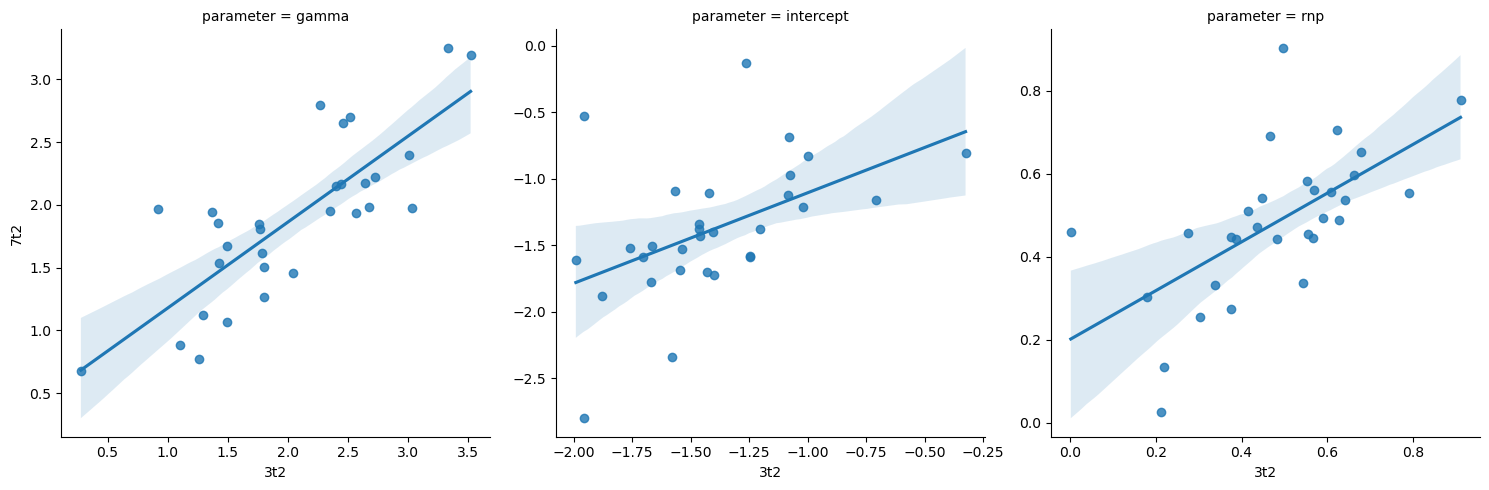

In [27]:
tmp = pars.unstack('session').stack('parameter')

sns.lmplot(tmp.reset_index(), x='3t2', y='7t2', col='parameter', sharex=False, sharey=False)
# plt.axhline(0.55, c='k', ls='--')
# plt.axhline(0.55, c='k', ls='--')
tmp

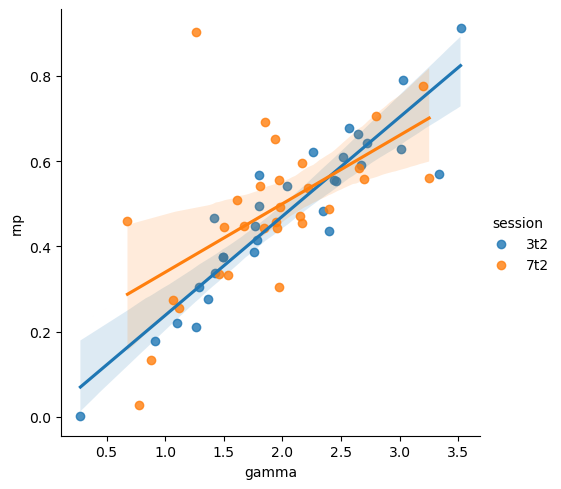

In [28]:
sns.lmplot(data=pars.reset_index(), x='gamma', y='rnp', hue='session')

In [31]:
tmp = r.join(pars)


tmp.groupby(['session', 'mask', 'n_voxels']).apply(lambda x: pingouin.corr(x['rnp'], x['r']))

n         r          CI95%     p-val   BF10  \
session mask n_voxels                                                         
3t2     npcl 0        pearson  30  0.302136   [-0.07, 0.6]  0.104647  0.798   
             100      pearson  30  0.183259  [-0.19, 0.51]  0.332374  0.355   
             250      pearson  30  0.104063  [-0.27, 0.45]  0.584208  0.262   
        npcr 0        pearson  30  0.059076  [-0.31, 0.41]  0.756490  0.238   
             100      pearson  30  0.166329   [-0.21, 0.5]  0.379697  0.328   
             250      pearson  30  0.098344  [-0.27, 0.44]  0.605143  0.258   
7t2     npcl 0        pearson  30  0.026032  [-0.34, 0.38]  0.891390  0.229   
             100      pearson  30 -0.101369  [-0.45, 0.27]  0.594029   0.26   
             250      pearson  30 -0.176819    [-0.5, 0.2]  0.349933  0.344   
        npcr 0        pearson  30 -0.005526  [-0.37, 0.36]  0.976879  0.227   
             100      pearson  30 -0.177643   [-0.51, 0.2]  0.347657  0.346   
             250      pearson  30 -0.192184  [-0.52, 0.18]  0.308948  0.372   

                                  power  
session mask n_voxels                    
3t2     npcl 0        pearson  0.375855  
             100      pearson  0.163974  
             250      pearson  0.084851  
        npcr 0        pearson  0.060686  
             100      pearson  0.142895  
             250      pearson  0.080987  
7t2     npcl 0        pearson  0.051646  
             100      pearson  0.083002  
             250      pearson  0.155681  
        npcr 0        pearson  0.049584  
             100      pearson  0.156722  
             250      pearson  0.176029

In [32]:
tmp.groupby(['session', 'mask', 'n_voxels']).apply(lambda x: pingouin.corr(x['gamma'], x['r']))

n         r          CI95%     p-val   BF10  \
session mask n_voxels                                                         
3t2     npcl 0        pearson  30  0.406591   [0.05, 0.67]  0.025768  2.434   
             100      pearson  30  0.334693  [-0.03, 0.62]  0.070632   1.08   
             250      pearson  30  0.193531  [-0.18, 0.52]  0.305504  0.375   
        npcr 0        pearson  30  0.174431    [-0.2, 0.5]  0.356584  0.341   
             100      pearson  30  0.266269   [-0.1, 0.57]  0.154947  0.596   
             250      pearson  30  0.216536  [-0.16, 0.54]  0.250424  0.426   
7t2     npcl 0        pearson  30  0.492737   [0.16, 0.72]  0.005669  8.736   
             100      pearson  30  0.167752    [-0.2, 0.5]  0.375575   0.33   
             250      pearson  30  0.236574  [-0.14, 0.55]  0.208151  0.484   
        npcr 0        pearson  30  0.435434   [0.09, 0.69]  0.016171  3.586   
             100      pearson  30  0.309646   [-0.06, 0.6]  0.095884  0.853   
             250      pearson  30  0.265713   [-0.1, 0.57]  0.155844  0.594   

                                  power  
session mask n_voxels                    
3t2     npcl 0        pearson  0.623364  
             100      pearson  0.450102  
             250      pearson  0.177905  
        npcr 0        pearson  0.152691  
             100      pearson  0.300895  
             250      pearson  0.212240  
7t2     npcl 0        pearson  0.811646  
             100      pearson  0.144577  
             250      pearson  0.245645  
        npcr 0        pearson  0.691142  
             100      pearson  0.392531  
             250      pearson  0.299800

In [43]:
tmp = decoded_stimuli.groupby(['subject', 'session', 'mask', 'n_voxels']).mean().join(pars)
tmp.groupby(['session', 'mask', 'n_voxels']).apply(lambda x: pingouin.corr(x['rnp'], x['sd']))

n         r           CI95%     p-val    BF10  \
session mask n_voxels                                                           
3t2     npcl 0        pearson  30 -0.547811  [-0.76, -0.23]  0.001727  24.512   
             100      pearson  30  0.094395   [-0.28, 0.44]  0.619778   0.255   
             250      pearson  30  0.207021   [-0.17, 0.53]  0.272352   0.403   
        npcr 0        pearson  30 -0.438759  [-0.69, -0.09]  0.015287   3.759   
             100      pearson  30  0.201414   [-0.17, 0.52]  0.285837   0.391   
             250      pearson  30  0.278234   [-0.09, 0.58]  0.136547   0.654   
7t2     npcl 0        pearson  30 -0.308099    [-0.6, 0.06]  0.097641   0.841   
             100      pearson  30 -0.176208     [-0.5, 0.2]  0.351626   0.343   
             250      pearson  30 -0.002739   [-0.36, 0.36]  0.988539   0.227   
        npcr 0        pearson  30 -0.182620   [-0.51, 0.19]  0.334093   0.354   
             100      pearson  30 -0.066905    [-0.42, 0.3]  0.725382   0.241   
             250      pearson  30  0.071496    [-0.3, 0.42]  0.707334   0.243   

                                  power  
session mask n_voxels                    
3t2     npcl 0        pearson  0.900015  
             100      pearson  0.078458  
             250      pearson  0.197514  
        npcr 0        pearson  0.698727  
             100      pearson  0.189182  
             250      pearson  0.324971  
7t2     npcl 0        pearson  0.389072  
             100      pearson  0.154912  
             250      pearson  0.049511  
        npcr 0        pearson  0.163136  
             100      pearson  0.063886  
             250      pearson  0.065956

In [37]:
tmp = decoded_stimuli.groupby(['subject', 'session', 'mask', 'n_voxels']).mean().join(pars)
tmp.groupby(['session', 'mask', 'n_voxels']).apply(lambda x: pingouin.corr(x['gamma'], x['sd']))

n         r           CI95%     p-val    BF10  \
session mask n_voxels                                                           
3t2     npcl 0        pearson  30 -0.555788  [-0.76, -0.24]  0.001429  28.935   
             100      pearson  30  0.008765   [-0.35, 0.37]  0.963334   0.227   
             250      pearson  30  0.179948   [-0.19, 0.51]  0.341335    0.35   
        npcr 0        pearson  30 -0.482224  [-0.72, -0.15]  0.006963   7.324   
             100      pearson  30  0.078537   [-0.29, 0.43]  0.679953   0.246   
             250      pearson  30  0.198135   [-0.17, 0.52]  0.293916   0.384   
7t2     npcl 0        pearson  30 -0.436284  [-0.69, -0.09]  0.015941    3.63   
             100      pearson  30 -0.009638   [-0.37, 0.35]  0.959687   0.227   
             250      pearson  30  0.290473   [-0.08, 0.59]  0.119430   0.722   
        npcr 0        pearson  30 -0.384146  [-0.65, -0.03]  0.036097   1.847   
             100      pearson  30 -0.051035    [-0.4, 0.32]  0.788832   0.235   
             250      pearson  30  0.198309   [-0.17, 0.52]  0.293486   0.384   

                                  power  
session mask n_voxels                    
3t2     npcl 0        pearson  0.910192  
             100      pearson  0.049732  
             250      pearson  0.159667  
        npcr 0        pearson  0.791426  
             100      pearson  0.069411  
             250      pearson  0.184430  
7t2     npcl 0        pearson  0.693086  
             100      pearson  0.049783  
             250      pearson  0.350586  
        npcr 0        pearson  0.569105  
             100      pearson  0.057826  
             250      pearson  0.184679

In [34]:
tmp

E         sd       rnp  intercept  \
subject session mask n_voxels                                              
02      3t2     npcl 0         41.340987  18.804510  0.609926  -1.244545   
                     100       41.393723  19.795891  0.609926  -1.244545   
                     250       34.742464  15.420361  0.609926  -1.244545   
                npcr 0         40.016717  18.611719  0.609926  -1.244545   
                     100       37.343659  16.811875  0.609926  -1.244545   
...                                  ...        ...       ...        ...   
32      7t2     npcl 100       38.404537  17.813382  0.026833  -2.799025   
                     250       31.889766  12.554170  0.026833  -2.799025   
                npcr 0         33.138519  12.998257  0.026833  -2.799025   
                     100       37.794218  16.198709  0.026833  -2.799025   
                     250       32.407509  12.415342  0.026833  -2.799025   

                                  gamma  
subject session mask n_voxels            
02      3t2     npcl 0         2.517197  
                     100       2.517197  
                     250       2.517197  
                npcr 0         2.517197  
                     100       2.517197  
...                                 ...  
32      7t2     npcl 100       0.773611  
                     250       0.773611  
                npcr 0         0.773611  
                     100       0.773611  
                     250       0.773611  

[360 rows x 5 columns]